In [15]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    print(dirname)
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input
/kaggle/input/cat-and-dog
/kaggle/input/cat-and-dog/test_set
/kaggle/input/cat-and-dog/test_set/test_set
/kaggle/input/cat-and-dog/test_set/test_set/dogs
/kaggle/input/cat-and-dog/test_set/test_set/cats
/kaggle/input/cat-and-dog/training_set
/kaggle/input/cat-and-dog/training_set/training_set
/kaggle/input/cat-and-dog/training_set/training_set/dogs
/kaggle/input/cat-and-dog/training_set/training_set/cats


In [16]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense, BatchNormalization
from keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.models import load_model
from keras.preprocessing import image
from sklearn.metrics import accuracy_score
from keras.optimizers import Adam
import keras.backend as K
import tensorflow as tf
import numpy as np
import os
import time

In [17]:
train_dir = "../input/cat-and-dog/training_set/training_set"
test_dir = "../input/cat-and-dog/test_set/test_set"

In [18]:
os.listdir("../input/cat-and-dog/training_set/training_set")

['dogs', 'cats']

(375, 499, 3)
(256, 192, 3)


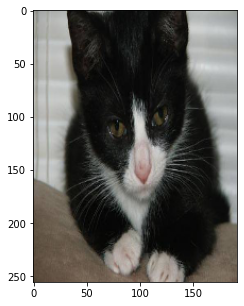

In [19]:
import cv2
import matplotlib.pyplot as plt

#get image size from dataset
img = load_img('/kaggle/input/cat-and-dog/training_set/training_set/cats/cat.2750.jpg')  # this is a PIL image
x = img_to_array(img)
print(x.shape)
plt.figure(figsize=(5,5))
x = cv2.resize(x, (192, 256))
print(x.shape)
plt.imshow(x/255)

In [20]:
batch_size = 64
lr = 3e-3

In [21]:
train_datagen = ImageDataGenerator(
    rescale = 1./255,
    rotation_range=0.3,
    shear_range=0.2,
    zoom_range=0.5,
    validation_split=0.2
)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(x.shape[0], x.shape[1]),
    batch_size= batch_size,
    class_mode='binary',
    subset='training'
)

valid_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size = (x.shape[0], x.shape[1]),
    batch_size = batch_size,
    class_mode = "binary",
    subset = "validation"
)


# valid_datagen = ImageDataGenerator(
#     rescale=1./255)

Found 6404 images belonging to 2 classes.
Found 1601 images belonging to 2 classes.


In [22]:
# test_datagen = ImageDataGenerator(rescale = 1./255)
# test_set = test_datagen.flow_from_directory(test_dir,
#                                             target_size=(x.shape[0], x.shape[1]),
#                                             batch_size = batch_size,
#                                             class_mode = 'binary')

In [23]:
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

gamma = 2.0
epsilon = K.epsilon()
def focal_loss(y_true, y_pred):
    pt = y_pred * y_true + (1-y_pred) * (1-y_true)
    pt = K.clip(pt, epsilon, 1-epsilon)
    CE = -K.log(pt)
    FL = K.pow(1-pt, gamma) * CE
    loss = K.sum(FL, axis=1)
    return loss

In [24]:
model = Sequential()
model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape=(x.shape[0], x.shape[1], 3)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, (3, 3)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors
model.add(Dense(512))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dense(512))
model.add(BatchNormalization())
model.add(Activation('relu'))
# model.add(Dropout(0.5))
model.add(Dense(1))
model.add(Activation('sigmoid'))

In [25]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 254, 190, 32)      896       
_________________________________________________________________
batch_normalization_5 (Batch (None, 254, 190, 32)      128       
_________________________________________________________________
activation_6 (Activation)    (None, 254, 190, 32)      0         
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 127, 95, 32)       0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 125, 93, 64)       18496     
_________________________________________________________________
batch_normalization_6 (Batch (None, 125, 93, 64)       256       
_________________________________________________________________
activation_7 (Activation)    (None, 125, 93, 64)      

In [26]:
model.compile(optimizer=Adam(lr),
              loss="binary_crossentropy",   
              metrics=["accuracy",f1_m,precision_m, recall_m])

In [31]:


epochs = 80

early_stop = EarlyStopping(patience=10, verbose=1, monitor='val_f1_m', mode='max')
reduce_lr =  ReduceLROnPlateau(monitor='val_f1_m', factor=0.1, patience=7, min_delta=1e-4, mode='max')
checkpoint = ModelCheckpoint(os.path.join("models.h5"), save_weights_only=True,
                             verbose=1, save_best_only=True, monitor='val_f1_m', mode='max')

In [32]:
#training the model
history = model.fit(
        train_generator,
        steps_per_epoch = int(train_generator.samples) // batch_size,
        validation_data = valid_generator,
        epochs = epochs,
        callbacks=[early_stop, checkpoint])

Epoch 1/80
100/100 [==============================] - 108s 1s/step - loss: 0.5970 - accuracy: 0.6765 - f1_m: 0.6674 - precision_m: 0.6917 - recall_m: 0.6548 - val_loss: 0.6770 - val_accuracy: 0.5834 - val_f1_m: 0.5533 - val_precision_m: 0.5619 - val_recall_m: 0.5504

Epoch 00001: val_f1_m improved from -inf to 0.55329, saving model to models.h5
Epoch 2/80
100/100 [==============================] - 109s 1s/step - loss: 0.5910 - accuracy: 0.6809 - f1_m: 0.6717 - precision_m: 0.6902 - recall_m: 0.6674 - val_loss: 0.6746 - val_accuracy: 0.5903 - val_f1_m: 0.6293 - val_precision_m: 0.5428 - val_recall_m: 0.7544

Epoch 00002: val_f1_m improved from 0.55329 to 0.62926, saving model to models.h5
Epoch 3/80
100/100 [==============================] - 107s 1s/step - loss: 0.5880 - accuracy: 0.6855 - f1_m: 0.6605 - precision_m: 0.7080 - recall_m: 0.6391 - val_loss: 0.6524 - val_accuracy: 0.6271 - val_f1_m: 0.5203 - val_precision_m: 0.6765 - val_recall_m: 0.4301

Epoch 00003: val_f1_m did not impro

In [52]:
import numpy as np
from keras.preprocessing import image

result = []

print("Predicting Cat Dataset:")
for img in os.listdir(f"{test_dir}/cats"):
#     os.system("cls")
    if img == "_DS_Store":
        continue

    test_image = image.load_img(f"{test_dir}/cats/{img}", target_size = (x.shape[0], x.shape[1]))
    test_image = image.img_to_array(test_image)
    test_image = np.expand_dims(test_image, axis = 0)/255
    if model.predict(test_image) < .5:
        result.append(1)
    else:
        result.append(0)
    

print("Accuracy for detcting only cat data: %.2f" %((sum(result)/len(result))*100))
print("Predicting Dog Dataset:")
for img in os.listdir(f"{test_dir}/dogs"):
    os.system("cls")
    if img == "_DS_Store":
        continue
#     print(img)
    test_image = image.load_img(f"{test_dir}/dogs/{img}", target_size = (x.shape[0], x.shape[1]))
    test_image = image.img_to_array(test_image)
    test_image = np.expand_dims(test_image, axis = 0)/255
    if model.predict(test_image) < .5:
        result.append(1)
    else:
        result.append(0)
        

        
print("Overall Accuracy: %.2f" %((sum(result)/len(result))*100))

Predicting Cat Dataset:
Accuracy for detcting only cat data: 90.31
Predicting Dog Dataset:
Overall Accuracy: 67.28
